# M2: Data gathering and preprocessing

Agustín Krebs, Axel Rusnok, Alex Sjöberg

## 1. Narrowing down the research question

In this project we want to build a RNN music generation model that is able to compose novel music in relation to other instrument notations. Our aim is to then be ablo to test this model using different genres of music (determined by metadata) to observe if certain genres are more learnable or have more simple relationships between the different instruments.  
  
These questions substantially narrows down our initial focus in multiple ways. Particularly, it gives us a more concrete and measurable question to try to answer that is less reliant on extremely latent features like emotion. It also makes it substantially easier to preprocess our data and gives us more reliable metadata/ labels. It also leads us to a more specific architecture from the few we proposed, a RNN. It also removes the need to use humans to evaluate our work or create labels, saving time and complexity. In general it is a substantially more focused and achievable set of goals. 
  
For this project, we are starting with the Lakh MIDI dataset composed as 176,581 MIDI files, labeled with artist, song title, and genre tags. We will separate it by instrument and then seperate each song into smaller subsets for training. Potentially we will augment this with other MIDI datasets if we feel it is necessary. 
  
If we talk about the files format, the MIDI extension suits as perfectly because it separated tracks into instrument channels, and this particular dataset is perfect because it has genre tags, and most songs have multiple tags, allowing us to expand our training sets for each genre. 
  
We think we will be able to create our generator, and (hopefully) will observe some differences between genres. Particularly, we have a feeling that pop and punk genres will be easier to generate, whereas more complicated musical styles with longer term (or more abstract relationships between instruments) will be harder to generate convincingly. At the end we should also be able to create some totally novel compositions with all channels being generated. 

Our measure of success will be how closely we are able to reproduce the correct compositions from songs in the test dataset. For example, we will provide bass and drum tracks from an existing song and then test the model’s ability to generate the corresponding guitar track. Obviously there are many ways to make a matching composition, but we should be able to determine if a correlation, whether it is in the time or note dimension, is significant and thus indicates the model successfully learned a style. Regardless of how successful the model is at generating convincing reproductions, we can compare different genres between each other and determine which is the easiest to reproduce. 

## 2. Gathering the data

For this project, we are using the dataset that is provided by Colin Raffel under CC-BY 4.0 license which was created by him for his PhD Thesis: "Learning-Based Methods for Comparing Sequences, with Applications to Audio-to-MIDI Alignment and Matching".  
  
The dataset, either in full amount or subsets can be accessed here: https://colinraffel.com/projects/lmd/  
  
The maximum available data in theory is 176,581 deduped MIDI files of which ~ 45 000 have been matched to entries in the Million Song Dataset. Of the later subset we also have matched metadata on every entry. Using 7digital key codes we can also access spotify's public API to gather more metadata if we need it.  
  
Regarding Milestone 3, now we have already accessed all the midi-files and metadata provided by Colin Raffel, however we need to conduct research on how reliable the metadata is and see if there is a need to gather more data from Spotify’s API. The metadata that we are particularly concerned with is the genre tags. We need to assess whether or not these are reliable in the data we currently have. 
  
Also, later we would have to see if 45,000 tracks is enough for the model to generalize and be able to generate something "decent". However, this could be potentially risky since we won't have the same metadata source for that other dataset.

## 3. Data format

Our main preprocessing target for now is to be able to extract the different instrument's tracks and match the metadata for the songs.

Until now, we have been using the pretty_midi library, with which we can easily extract all the main features of the track that we need. The most key method of this library is the one which allows to extract each instrument track of the MIDI files, thus enabling us to feed the model this inputs separately.

### Extracting instruments tracks  

Here you can see an example of a MIDI file where we can extract/separate the instruments involved. First, we can get a list of all the instruments that take part of the song. As you can see, the library also differentiates drums from other instruments (since they don't have pitches and need to be treated differently).

In [54]:
import pretty_midi
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import mir_eval
import mir_eval.display
import json
import tables
import os

midi_PATH = "Radiohead - Creep.mid"
pm = pretty_midi.PrettyMIDI(midi_PATH)
pm.instruments

[Instrument(program=0, is_drum=True, name=""),
 Instrument(program=0, is_drum=True, name=""),
 Instrument(program=75, is_drum=False, name=""),
 Instrument(program=52, is_drum=False, name=""),
 Instrument(program=42, is_drum=False, name=""),
 Instrument(program=0, is_drum=False, name=""),
 Instrument(program=33, is_drum=False, name=""),
 Instrument(program=29, is_drum=False, name=""),
 Instrument(program=0, is_drum=False, name=""),
 Instrument(program=62, is_drum=False, name=""),
 Instrument(program=0, is_drum=True, name="")]

In this song there are 11 instruments involded. Now, we can plot a piano roll representation of all of them together:

Text(0.5, 1.0, 'MIDI piano roll')

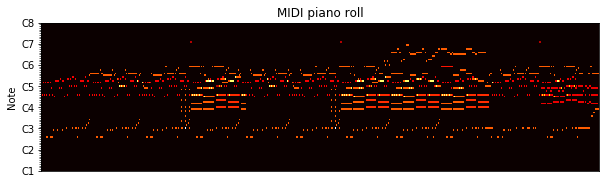

In [55]:
# Retrieve piano roll of the MIDI file
piano_roll = pm.get_piano_roll()
# Use 7 octaves starting from C1
piano_roll = piano_roll[12:96]
# Plot
plt.figure(figsize=(10, 6))
plt.subplot(211)
librosa.display.specshow(piano_roll, y_axis='cqt_note', cmap=plt.cm.hot)
plt.title('MIDI piano roll')

Now, we can separate each individual instrument of the song. For example here, we just want the 8th instrument on the instruments list. The library also provides a conversion between the instrument "program id" to the actual name of it.

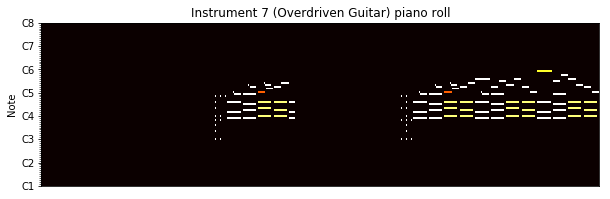

In [59]:
instrument_index = 7

# Retrieve piano roll of one of the instruments
piano_roll = pm.instruments[instrument_index].get_piano_roll()
piano_roll = piano_roll[12:96]
plt.figure(figsize=(10, 3))
librosa.display.specshow(piano_roll, y_axis='cqt_note', cmap=plt.cm.hot)
# Get the text name of this instrument's program number
program_name = pretty_midi.program_to_instrument_name(pm.instruments[instrument_index].program)
plt.title(f'Instrument {instrument_index} ({program_name}) piano roll');

Now we can plot the same with direct access to the pitch and start/end time of each note:

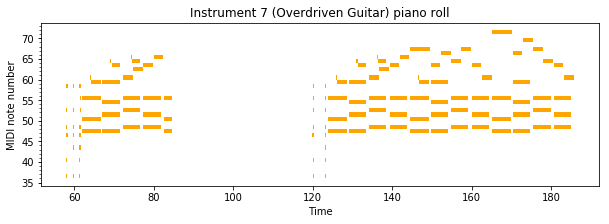

In [57]:
intervals = np.array([[note.start, note.end] for note in pm.instruments[instrument_index].notes])
notes = np.array([note.pitch for note in pm.instruments[instrument_index].notes])
plt.figure(figsize=(10, 3))
mir_eval.display.piano_roll(intervals, midi=notes, facecolor='orange')
plt.title(f'Instrument {instrument_index} ({program_name}) piano roll')
plt.xlabel('Time')
plt.ylabel('MIDI note number');

From this section, we have 2 main decisions to make (or questions to answer) for the next Milestone:  
- How are we going to enconde each separate instrument track to feed it to the model, since it's no longer a MIDI file?
- Which subset of instruments are we going to consider, to narrow down our model's scope?

For the first question, we were planning on using 'abc format', which maps the song information into a text representation. Even though one of our group member manages this encoding, we should definetely do more research about it and check other options.

As for the second question, we can see that the library works with 128 instruments, from which we have to decide a subset, and also make a "equivalence mapping" between instruments (for example, merging all the pianos). In that sense, we were planning in taking just "common" instruments, such as drums, bass and guitar, but then again, it would depend in this "equivalence mapping" that we have to develop. Here you can see all the instruments available:

In [60]:
for i in range(128):
    program_name = pretty_midi.program_to_instrument_name(i)
    print(program_name)

Acoustic Grand Piano
Bright Acoustic Piano
Electric Grand Piano
Honky-tonk Piano
Electric Piano 1
Electric Piano 2
Harpsichord
Clavinet
Celesta
Glockenspiel
Music Box
Vibraphone
Marimba
Xylophone
Tubular Bells
Dulcimer
Drawbar Organ
Percussive Organ
Rock Organ
Church Organ
Reed Organ
Accordion
Harmonica
Tango Accordion
Acoustic Guitar (nylon)
Acoustic Guitar (steel)
Electric Guitar (jazz)
Electric Guitar (clean)
Electric Guitar (muted)
Overdriven Guitar
Distortion Guitar
Guitar Harmonics
Acoustic Bass
Electric Bass (finger)
Electric Bass (pick)
Fretless Bass
Slap Bass 1
Slap Bass 2
Synth Bass 1
Synth Bass 2
Violin
Viola
Cello
Contrabass
Tremolo Strings
Pizzicato Strings
Orchestral Harp
Timpani
String Ensemble 1
String Ensemble 2
Synth Strings 1
Synth Strings 2
Choir Aahs
Voice Oohs
Synth Choir
Orchestra Hit
Trumpet
Trombone
Tuba
Muted Trumpet
French Horn
Brass Section
Synth Brass 1
Synth Brass 2
Soprano Sax
Alto Sax
Tenor Sax
Baritone Sax
Oboe
English Horn
Bassoon
Clarinet
Piccolo
Flut

### Separating into Genres

The other key part of our project is to be able to have the songs separated in genres. Most songs have tags in the metadata, these are used to form the genres which we, at a later stage, will use as a basis for our analysis. Next you can see a snippet of code that allows to get this metadata from the songs. Even though the metadata was available, the matching with the MIDI files was not direct, since they come from different datasets that you have to relate according to some methods provided from the Million Songs Datasets.

In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pretty_midi
import librosa
import mir_eval
import mir_eval.display
import tables
import IPython.display
import os
import json
import hdf5_getters as getters

# Local path constants
DATA_PATH = 'data'
RESULTS_PATH = 'Data'
# Path to the file match_scores.json distributed with the LMD
SCORE_FILE = os.path.join(RESULTS_PATH, 'match_scores.json')

# Utility functions for retrieving paths
def msd_id_to_dirs(msd_id):
    """Given an MSD ID, generate the path prefix.
    E.g. TRABCD12345678 -> A/B/C/TRABCD12345678"""
    return os.path.join(msd_id[2], msd_id[3], msd_id[4], msd_id)

def msd_id_to_mp3(msd_id):
    """Given an MSD ID, return the path to the corresponding mp3"""
    return os.path.join(DATA_PATH, 'msd', 'mp3',
                        msd_id_to_dirs(msd_id) + '.mp3')

def msd_id_to_h5(h5):
    """Given an MSD ID, return the path to the corresponding h5"""
    return os.path.join(RESULTS_PATH, 'lmd_matched_h5',
                        msd_id_to_dirs(msd_id) + '.h5')

def get_midi_path(msd_id, midi_md5, kind):
    """Given an MSD ID and MIDI MD5, return path to a MIDI file.
    kind should be one of 'matched' or 'aligned'. """
    return os.path.join(RESULTS_PATH, 'lmd_{}'.format(kind),
                        msd_id_to_dirs(msd_id), midi_md5 + '.mid')

def get_most_helper(msd_id):
    with tables.open_file(msd_id_to_h5(msd_id)) as h5:
        return list(h5.root.metadata.artist_terms)[:5]

def get_most_common(m_id,n):
    msd_id = m_id
    temp_list = []
    l = get_most_helper(m_id)
    for i in l:
        #print(i.decode('UTF-8'))
        temp_list.append(i.decode('UTF-8'))
    return  temp_list

def add_msd_to_genres(dictionary, m_id, n):
    msd_id = m_id
    temp_list = get_most_common(m_id,n)
    for i in temp_list:
        # Check if it is in the dict before otherwise add it
        if i in dictionary:
            dictionary[i].append(m_id)
        else:
            dictionary[i] = [m_id]
    return

def get_all_genres(n):
    d = {}
    end_i = len(list(scores.keys()))-1
    for i in range(0,end_i):
        msd_id = list(scores.keys())[i]
        add_msd_to_genres(d,msd_id,n)
    return d

In [456]:
d = get_all_genres(5)
dist = get_genre_dist(d)
d.keys()

dict_keys(['opera', 'bel canto', 'pop rock', 'pop', 'female vocalist', 'german pop', 'ballad', 'folk rock', 'disco', 'chanson', 'blues', 'rock', 'gnawa', 'instrumental pop', 'smooth jazz', 'free jazz', 'acid jazz', 'jazz funk', 'europop', 'j pop', 'italian disco', 'salsa', 'hard trance', 'downtempo', 'dub', 'chill-out', 'space music', 'trance', 'pop rap', 'progressive house', 'hip hop', 'happy hardcore', 'blues-rock', 'heavy metal', 'hard rock', 'glam rock', 'glitch', 'indie pop', 'intelligent dance music', 'portland', 'indietronica', 'vocal jazz', 'jazz', 'vocal', 'swing', 'soft rock', 'rockabilly', "rock 'n roll", 'electronic', 'eurodance', 'easy listening', 'orchestra', 'instrumental', 'classical', 'dance pop', 'teen pop', 'urban', 'boy band', 'adult contemporary', 'beat', 'club', 'remix', 'singer-songwriter', 'british pop', 'garage rock', 'new wave', 'game', 'england', 'college rock', 'new romantic', 'ragtime', 'cool jazz', 'jump blues', 'classic rock', 'metal', 'modern laika', 'ma

As one can see, there's a lot of genres involved in the dataset. Our aim is to be able to choose the most frequent ones. On the other hand, one song can have multiple genres associated to it (for example: rock, pop, indie), so we have to decide also which genres are not too present together in the datasets.  
  
Next you can see some frequencies of the genres:

In [61]:
dist

{'opera': 0.0033069610872128643,
 'bel canto': 0.00022397744415385932,
 'pop rock': 0.04110644857412007,
 'pop': 0.026600615279214236,
 'female vocalist': 0.0035902266783486275,
 'german pop': 0.006778611471597684,
 'ballad': 0.03389305735798842,
 'folk rock': 0.01036883814994631,
 'disco': 0.020612512434041937,
 'chanson': 0.008412329299543482,
 'blues': 0.006060566135927958,
 'rock': 0.042028708638283015,
 'gnawa': 1.3175143773756431e-05,
 'instrumental pop': 0.003333311374760377,
 'smooth jazz': 0.0040184188509957116,
 'free jazz': 0.0010276612143530015,
 'acid jazz': 0.0011396499364299314,
 'jazz funk': 0.0032608480840047166,
 'europop': 0.01876140473382916,
 'j pop': 0.0013175143773756432,
 'italian disco': 0.006673210321407632,
 'salsa': 0.0016337178279457974,
 'hard trance': 0.010243674284095625,
 'downtempo': 0.00653487131178319,
 'dub': 0.002970994920982075,
 'chill-out': 0.00907767406011818,
 'space music': 8.56384345294168e-05,
 'trance': 0.012200183134498456,
 'pop rap': 0.

Lastly, it is important to mention that, since both datasets were extremely big, we didn't have enough time to explore more the whole dataset and get some distributions or better statistics over the genres. That's for sure something we need to work on to make future decisions on the genres that we are going to consider.